# Single Neuron Experiments

This tutorial introduces [Norse](norse.ai) and the concept of spiking neurons.
In the next 5-10 minutes or so you will learn about

- Spiking Neuron Models
- Gradient based learning with Spiking Neurons

## Step 0: Installation

First of all, we will need to install Norse. Please run the cell below. Read on while it's running.

In [1]:
#!pip install --quiet norse
#!pip install show
#from show import *

import torch
import norse
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['legend.frameon'] = False



In [2]:
import norse
from jithub.models import model_classes
model = model_classes.ADEXPModel()
from norse.torch.functional.lif import lif_step #there model
from neuronunit.optimization.model_parameters import MODEL_PARAMS#, BPO_PARAMS

MODEL_PARAMS['IZHI']

OrderedDict([('C', [20, 200]),
             ('k', [0.25, 1.6]),
             ('vr', [-75, -55]),
             ('vt', [-50, -40]),
             ('vPeak', [0, 50]),
             ('a', [0.01, 0.2]),
             ('b', [-2, 15]),
             ('c', [-60, -40]),
             ('d', [-55, 150]),
             ('celltype', [3, 7])])

In [3]:

model = model_classes.ADEXPModel()


In [4]:
from jithub.models import model_classes
from norse.torch.functional.lif import lif_step, LIFParameters, LIFState
       
class MyHackedNeurons(torch.nn.Module):
    def __init__(self, current_gain, alpha):
        super(MyHackedNeurons, self).__init__()
        self.hidden_size = hidden_size
        self.w_in = torch.nn.Parameter(torch.tensor(current_gain).float())
        self.w_rec = torch.zeros(hidden_size, hidden_size) # no recurrent connections
        
        self.lambda_vs = []
        self.lambda_is = []
       
        self.p = {k:np.mean(v) for k,v in MODEL_PARAMS['IZHI'].items()}
        self.p["celltype"] = 3

    def reset_lambda_recording(self):
        self.lambda_vs = []
        self.lambda_is = []

    def forward(self, z_in):
        seq_length, batch_size, _ = z_in.shape
        hidden_size = self.hidden_size

        s = LIFState(
            v = torch.zeros(batch_size, hidden_size, requires_grad=True),
            i = torch.zeros(batch_size, hidden_size, requires_grad=True),
            z = torch.zeros(batch_size, hidden_size)
        )
        voltages = torch.zeros(seq_length, batch_size, hidden_size)
        currents = torch.zeros(seq_length, batch_size, hidden_size)
        #print(currents)
        z_s = torch.zeros(seq_length, batch_size, hidden_size)

        def save_lambda_v(grad):
            if grad is not None:
                self.lambda_vs.append(grad)

        def save_lambda_i(grad):
            if grad is not None:
                self.lambda_is.append(grad)

                
        model = model_classes.IzhiModel()
        model.set_attrs(self.p)
        #print([i for i in s.i])
        syn_current = []
        for ts in range(seq_length):
            """
            This is where the optimized singular LIF model is solved for
            """
            self.p2 = LIFParameters(alpha=alpha)

            z, s = lif_step(z_in[ts], s, self.w_in, self.w_rec, p=self.p2)

            # record the gradient in the backward pass
            s.v.register_hook(save_lambda_v)
            s.i.register_hook(save_lambda_i)
            # save the voltage + synaptic input current state
            voltages[ts,:] = s.v
            currents[ts, :] = s.i
            syn_current.append(s.i)

            z_s[ts,:] = z
        plt.plot(voltages,seq_length)
        plt.show()
        self.syn_current1 = [i.item() for i in syn_current]    
        #self.syn_current2 = [i[1] for i in syn_current]    

        #print(self.syn_current1)

        #model.inject_direct_current(syn_current)
        #voltages = model.get_membrane_potential()

        #print(self.p)
        #print(z_in, s, self.w_in, self.w_rec,)
        
        return z_s,self.syn_current1#, voltages, currents
    
    
seq_length = 1000
input_size = 50
hidden_size = 1
batch_size = 1
epochs = 100
alpha = 100.0
target_times = [100, 300, 500, 700, 900]


w_in = np.random.randn(hidden_size,input_size)* np.sqrt(2/hidden_size)
spikes = torch.distributions.bernoulli.Bernoulli(probs=0.04*torch.ones(seq_length, batch_size, input_size))
z_in = spikes.sample()    
alpha = 100.0
current_gain = w_in
neuron_model = MyHackedNeurons(w_in,alpha)
#z_s,syn_current1 = neuron_model.forward(z_in)
#print(w_in[0,0]*neuron_model.syn_current1[0])

In [5]:

from neuronunit.tests.target_spike_current import SpikeCountSearch
import quantities as qt

class Neurons(torch.nn.Module):
    def __init__(self, weights, alpha, nspikes):
        super(Neurons, self).__init__()
        self.hidden_size = hidden_size
        self.w_in = torch.nn.Parameter(torch.tensor(weights).float())
        self.w_rec = torch.zeros(hidden_size, hidden_size) # no recurrent connections
        self.nspikes = nspikes
        self.lambda_vs = []
        self.lambda_is = []
        self.p = LIFParameters(alpha=alpha)

    def reset_lambda_recording(self):
        self.lambda_vs = []
        self.lambda_is = []
        
    def forward(self, input_spikes):

        params = {}
        i = 0
        for k,j in MODEL_PARAMS['ADEXP'].items():
            wv = self.w_in.detach().numpy()[0]
            params[k] = np.mean([wv*j[0],wv*j[1]])
            i += 1
        model = model_classes.ADEXPModel()
        #params["celltype"] = int(params["celltype"])
        model.attrs = params
        
        observation = {}
        observation["value"] = self.nspikes
        scs = SpikeCountSearch(observation)
        target_current = scs.generate_prediction(model)
        inject_param = {
            "padding":0 * qt.ms,
            "delay": 0 * qt.ms,
            "amplitude": 900 * qt.pA,
            "duration": 1000 * qt.ms,
            "dt":0.25
        }
        try:
            inject_param["amplitude"] = target_current["value"]* qt.pA
            model.inject_square_current(**inject_param)
            vm = model.get_membrane_potential()
            print(model.attrs)
            print(self.w_in.detach().numpy())
            
            plt.plot(vm.times,vm)
            plt.show()

            concise_spk_time = model.get_spike_train()
        except:
            concise_spk_time = []
        #output_spikes[ts,:] = 


        seq_length, batch_size, _ = z_in.shape

        hidden_size = self.hidden_size
        output_spikes = torch.zeros(seq_length, batch_size, hidden_size)

        s = LIFState(
            v = torch.zeros(batch_size, hidden_size, requires_grad=True),
            i = torch.zeros(batch_size, hidden_size, requires_grad=True),
            z = torch.zeros(batch_size, hidden_size)
        )
        voltages = torch.zeros(seq_length, batch_size, hidden_size)
        currents = torch.zeros(seq_length, batch_size, hidden_size)


        def save_lambda_v(grad):
            if grad is not None:
                self.lambda_vs.append(grad)

        def save_lambda_i(grad):
            if grad is not None:
                self.lambda_is.append(grad)

        for ts in range(seq_length):
            """
            This is where the optimized singular LIF model is solved for
            """
            z, s = lif_step(input_spikes[ts], s, self.w_in, self.w_rec, p=self.p)

            # record the gradient in the backward pass
            s.v.register_hook(save_lambda_v)
            s.i.register_hook(save_lambda_i)

            # save the voltage + synaptic input current state
            voltages[ts,:] = s.v
            currents[ts, :] = s.i
            output_spikes[ts,:] = z
        #print(output_spikes)
        #print(np.shape(z_in.detach().data))
        """
        
        #print(np.shape(voltages.detach().data))
        print("Parameters not changed \n\n\n")
        print(self.p)
        print("wheights \n\n\n")
        print(self.w_in)
        print("Voltage \n\n\n")
        plt.plot([ts for ts in range(seq_length)],z_in.detach().data[:,0,:])
        plt.show()            
        print("Voltage \n\n\n")

        plt.plot([ts for ts in range(seq_length)],voltages.detach().data[:,0,0])
        plt.show()            
        print("current \n\n\n")
        plt.plot([ts for ts in range(seq_length)],currents.detach().data[:,0,0])
        plt.show()            
        print("output spikes \n\n\n")
        plt.plot([ts for ts in range(seq_length)],output_spikes.detach().data[:,0,0])
        plt.show()            
        """
        
        
        #print(self.p)
        #output_spikes = z_s
        return output_spikes, voltages, currents, concise_spk_time

In [6]:
#from neuronunit import tests
#dir(tests)

## Step 1: A simple neuron model

The point neuron models supported by Norse are almost all variants of the Leaky-Integrate and Fire neuron model. It is however relatively easy to implement your own model. The library
is build in layers, here I show an example of how to use the functional API directly. To
build large scale machine learning models, you should check out the tutorial on [PyTorch
lightning + Norse](high-performance-computing.ipynb).


In [7]:
#help(lif_step)
#print(target_spikes)

## Step 2.1: Optimizing for a fixed number of spikes

A simple task to consider is a single neuron stimulated at different times by $k$ fixed poisson distributed spike trains, with synaptic weights distributed according to a gaussian distribution. The goal is for the neuron to respond to these fixed spike trains with a certain number of spikes $n_\text{target}$ within a time $T$. The loss in this case is
$$
l = -n_\text{target}/T + \sum_i \delta(t - t_i) 
$$
so
$$
S = \int_0^T (-n_\text{target}/T + \sum_i \delta(t - t_i)) dt = n_\text{actual} - n_\text{target}
$$

In [8]:
from tqdm.notebook import trange

def run_training(
    w_in,
    z_in,
    alpha=100.0,
    max_epochs=100,
    target_spikes=6,
    target_spike_offset=10
):
    neurons = Neurons(w_in, alpha=torch.tensor(alpha),nspikes=target_spikes)
    
    #neurons = MyHackedNeurons(w_in, alpha=torch.tensor(alpha))
    #print(neurons.p,"this is the parameter set that controls the neuronal model")
    optim = torch.optim.SGD(neurons.parameters(), lr=0.1)

    lambda_vs = []
    lambda_is = []
    spikes_out = []
    vs = []
    cs = []

    pbar = trange(max_epochs)
    for e in pbar:
        optim.zero_grad()
        output_spikes, voltages, currents, concise_spk_time = neurons(z_in)
        
        

        # compute the loss according to the formula above
        loss = torch.sum(torch.abs((torch.sum(output_spikes, axis=0) - target_spikes)))
        loss.backward()

        pbar.set_postfix({"spike difference": loss.detach().item()})

        # keep track of the experiment data
        vs.append(voltages.detach().data)
        cs.append(currents.detach().data)     
        spikes_out.append(output_spikes.detach().data)
        lambda_vs.append(torch.stack(neurons.lambda_vs))
        lambda_is.append(torch.stack(neurons.lambda_is))
        neurons.reset_lambda_recording()

        if loss.data == torch.tensor([0.0]):
            break

        # do a gradient optimisation step
        optim.step()

    return spikes_out, vs, cs, lambda_vs, lambda_is

In [9]:
seq_length = 1000
input_size = 20
hidden_size = 1
batch_size = 1
epochs = 100
alpha = 100.0

spikes = torch.distributions.bernoulli.Bernoulli(probs=0.04*torch.ones(seq_length, batch_size, input_size))
spikes_in = spikes.sample()
w_in = np.random.randn(hidden_size,input_size) * np.sqrt(2/hidden_size)


In [10]:
w_in = [abs(i)/2.0 for i in w_in]
w_in

[array([0.31123416, 0.10983613, 0.24730012, 0.66575284, 1.03085984,
        0.37182927, 0.40449157, 0.31249831, 0.45074855, 0.29261833,
        0.21021151, 0.94595405, 1.09191238, 0.80404523, 0.05158682,
        0.39185489, 1.16193232, 1.1442845 , 0.58046256, 0.50677208])]

In [11]:
"""
print(np.shape(spikes_in.detach().data))

for i in range(0,len(spikes_in)-1):
    #print(i)
    try:
        print("input spikes")
        plt.plot([ts for ts in range(seq_length)],spikes_in.detach().data[:,0,i])
        plt.show()            
    except:
        pass
"""


'\nprint(np.shape(spikes_in.detach().data))\n\nfor i in range(0,len(spikes_in)-1):\n    #print(i)\n    try:\n        print("input spikes")\n        plt.plot([ts for ts in range(seq_length)],spikes_in.detach().data[:,0,i])\n        plt.show()            \n    except:\n        pass\n'

In [12]:
#plt.plot([i for i in range(0,len(w_in))],w_in)
#plt.show()            
#w_in

LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.)) this is the parameter set that controls the neuronal model


{'cm': 272.85873, 'v_spike': -24.943918, 'v_reset': -34.64433, 'v_rest': -37.415874, 'tau_m': 17.403498, 'a': 5.545864, 'b': 5.545864, 'delta_T': 3.048701, 'tau_w': 98.1266, 'v_thresh': -22.17237, 'spike_delta': 37.76232}
[[0.31123415 0.10983613 0.24730012 0.6657528  1.0308598  0.37182927
  0.40449157 0.3124983  0.45074856 0.29261833 0.2102115  0.945954
  1.0919124  0.80404526 0.05158682 0.39185488 1.1619323  1.1442845
  0.5804626  0.5067721 ]]


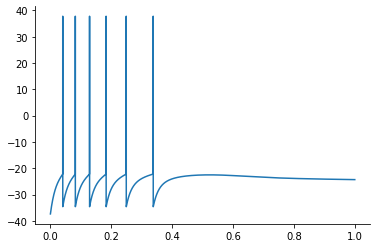

{'cm': 173.4224, 'v_spike': -15.853747, 'v_reset': -22.019094, 'v_rest': -23.78062, 'tau_m': 11.061239, 'a': 3.5248165, 'b': 3.5248165, 'delta_T': 1.9376805, 'tau_w': 62.366882, 'v_thresh': -14.092221, 'spike_delta': 24.000814}
[[ 0.07714634 -0.07049429  0.04679176  0.42720518  0.8574242   0.12343802
   0.16654567  0.08701214  0.30333522  0.06278649 -0.0048108   0.7992035
   0.95042765  0.6210982  -0.09576479  0.17463256  0.95843184  0.93377733
   0.29610115  0.33182284]]


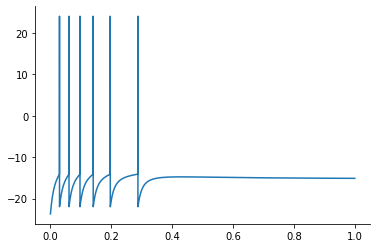

{'cm': 67.86476, 'v_spike': -6.203991, 'v_reset': -8.616654, 'v_rest': -9.305986, 'tau_m': 4.328555, 'a': 1.3793539, 'b': 1.3793539, 'delta_T': 0.7582655, 'tau_w': 24.405811, 'v_thresh': -5.5146585, 'spike_delta': 9.392153}
[[-0.14631848 -0.25290135 -0.11847807  0.10423211  0.735549   -0.17284942
  -0.0111432  -0.21886775  0.10216966 -0.14891239 -0.23751986  0.6391147
   0.74405086  0.4229465  -0.30947474 -0.05026532  0.67488134  0.6981562
   0.11872185  0.18423745]]


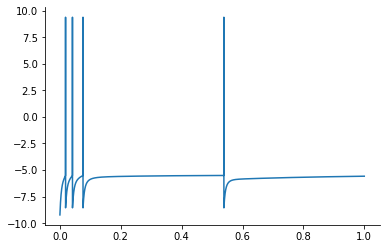

In [13]:



spikes, vs, cs, lambda_vs, lambda_is = run_training(z_in=spikes_in, w_in=w_in, alpha=alpha, target_spikes=6, max_epochs=epochs)

Don't worry that the progress bar turned red, in this case it means that the optimisation
finished early. We can plot the error signals that are propagated backwards in time as follows. At each spike that reaches the neuron at synapse the variable $\lambda_i$ is accumulated to the gradient
of the synaptic weight.

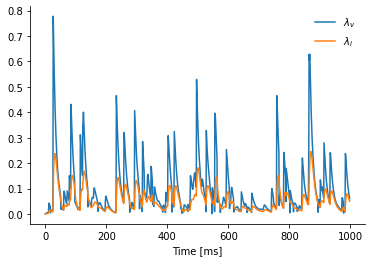

In [14]:
import matplotlib.pyplot as plt

epoch_from_last = 2
plt.plot(lambda_vs[-epoch_from_last][:,0], label='$\lambda_v$')
plt.plot(lambda_is[-epoch_from_last][:,0], label='$\lambda_i$')
plt.xlabel('Time [ms]')
plt.legend()
plt.show()

Exercises:
- Change the epoch_from_last variable to plot the error traces at different times in the optimisation
  procedure.
- Change the value alpha. What do you observe?
- Repeat the experiment with more biologically realistic parameters


In [15]:
#norse.torch.functional.lif.LIFParameters?
#print(dir(norse.torch.functional.lif.LIFParameters))
"""


where :math:`z_{\text{rec}}` and :math:`z_{\text{in}}` are the recurrent
and input spikes respectively.

Parameters:
    input_tensor (torch.Tensor): the input spikes at the current time step
    s (LIFState): current state of the LIF neuron
    input_weights (torch.Tensor): synaptic weights for incoming spikes
    recurrent_weights (torch.Tensor): synaptic weights for recurrent spikes
    p (LIFParameters): parameters of a leaky integrate and fire neuron
    dt (float): Integration timestep to use
"""

'\n\n\nwhere :math:`z_{\text{rec}}` and :math:`z_{\text{in}}` are the recurrent\nand input spikes respectively.\n\nParameters:\n    input_tensor (torch.Tensor): the input spikes at the current time step\n    s (LIFState): current state of the LIF neuron\n    input_weights (torch.Tensor): synaptic weights for incoming spikes\n    recurrent_weights (torch.Tensor): synaptic weights for recurrent spikes\n    p (LIFParameters): parameters of a leaky integrate and fire neuron\n    dt (float): Integration timestep to use\n'

## Step 2.2: Learning target spike times

Another task is for one neuron to spike at specific spike times $t_0, \ldots, t_N$ given that it stimulated 
by a fixed set of poisson distributed spikes. We can choose as a loss in this case
$$
l = \sum_i \lvert v - v_{\text{th}} \rvert^2 \delta(t - t_i) + l_N
$$
that is we require the membrane voltages to be close to the threshold $v_{th}$ at the required spike times $t_i$
and penalise the neuron if it spikes more or less than the required number of times.

In [16]:
from tqdm.notebook import trange

def run_target_spike_time_training(
    w_in,
    z_in,
    alpha=100.0,
    epochs=40000,
    target_times=[100, 300, 500, 700]
):
    #print("w_in",w_in)
    neurons = Neurons(w_in, alpha=torch.tensor(alpha),nspikes=len(target_times))
    params = neurons.parameters()

    optim = torch.optim.SGD(params, lr=0.1)

    lambda_vs = []
    lambda_is = []
    spikes_out = []
    vs = []
    cs = []
    

    v_target = torch.zeros(seq_length, batch_size, hidden_size)
    target_spikes = len(target_times)

    for time in target_times:  
        v_target[time,:] = 1.1 * torch.ones(hidden_size)
    
    pbar = trange(epochs)
    for e in pbar:
        optim.zero_grad()
        
        #print(z_in)
        z_s, voltages, currents, concise_spk_times = neurons(z_in)
        #print(currents)
        #print(z_s,'zs',type(z_s))
        loss = torch.zeros(1,1)
        
        print(target_times)
        #print(concise_spk_times)
        #deltas = []
        rescale = []
        if len(concise_spk_times):
            for gt,time in zip(target_times,concise_spk_times):
                tt = gt/1000.0
                rescale.append(tt)
                temp = 1/2 * 1/10 * (float(time)-tt)**2
                loss += temp
                #print(temp)
                #dspikes = torch.sum(torch.abs(torch.sum(z_s, axis=0) - target_spikes))
                #loss += dspikes
            print(rescale)
            print(concise_spk_times)

        else:
            for time in target_times:    
                loss += 10000.0
                #dspikes = torch.sum(torch.abs(torch.sum(z_s, axis=0) - target_spikes))
                #loss += 10000.0
        dspikes = np.sum(len(concise_spk_times) - target_spikes)
        loss += dspikes                
        print(loss)

        """
        for time in target_times:    
            loss += 1/2 * 1/10 * (voltages[time,:] - v_target[time,:])**2

        
        
        """
        #loss += deltas
        #loss.backward()

        #pbar.set_postfix({"loss": loss.detach().item(), "spike difference": dspikes.detach().item()})

        vs.append(voltages.detach().data)
        cs.append(currents.detach().data)
        spikes_out.append(z_s.detach().data)
        #lambda_vs.append(torch.stack(neurons.lambda_vs))
        #lambda_is.append(torch.stack(neurons.lambda_is))
        #print(neurons.p)
        neurons.lambda_vs = []
        neurons.lambda_is = []
        if loss==0.0:
            #if loss.data == torch.tensor([0.0]):
            break

        optim.step()
        #print(optim.param_groups,optim.state,optim.state_dict,optim.step,optim.zero_grad)
        #print(dir(optim))

    return spikes_out, vs, vs, lambda_vs, lambda_is

In [17]:
"""
neurons = Neurons(w_in, alpha=torch.tensor(alpha),nspikes=target_spikes)
params = neurons.parameters()
print([p for p in params])
params = neurons.parameters()

optim = torch.optim.SGD(params, lr=0.1)
print(neurons.p)
print(w_in)
"""

'\nneurons = Neurons(w_in, alpha=torch.tensor(alpha),nspikes=target_spikes)\nparams = neurons.parameters()\nprint([p for p in params])\nparams = neurons.parameters()\n\noptim = torch.optim.SGD(params, lr=0.1)\nprint(neurons.p)\nprint(w_in)\n'

{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


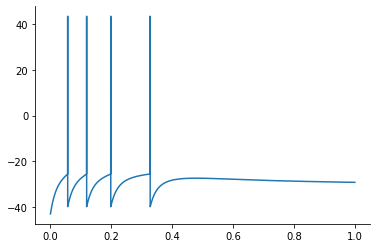

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


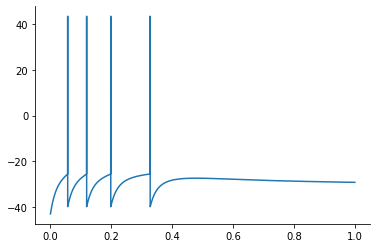

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


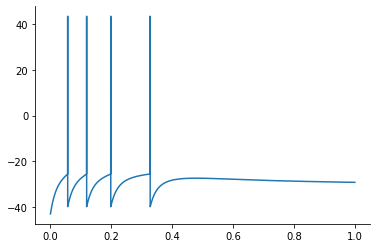

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


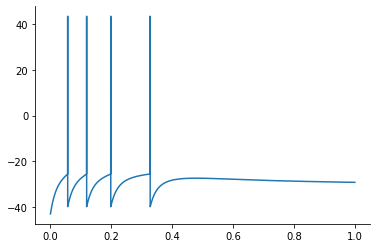

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


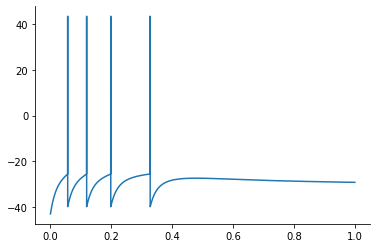

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


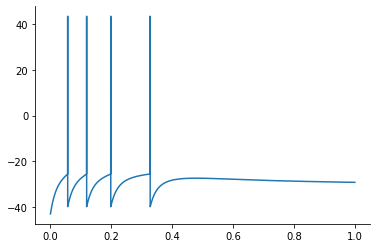

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


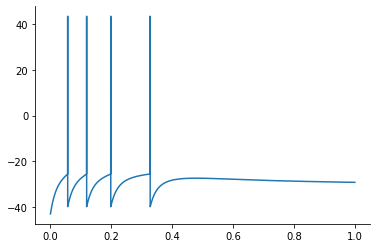

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


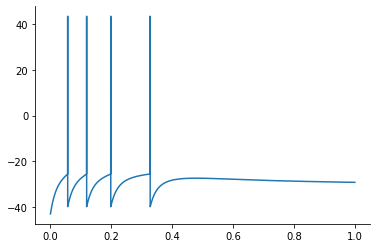

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


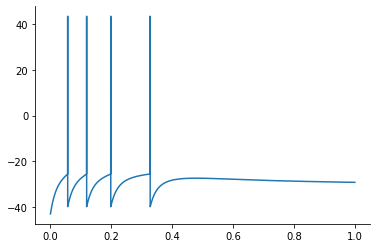

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


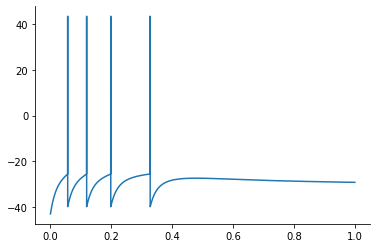

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


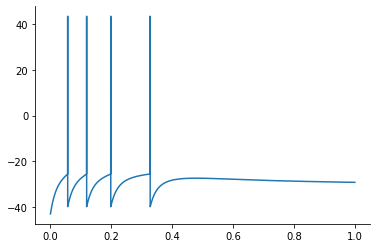

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


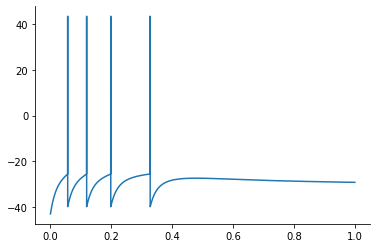

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


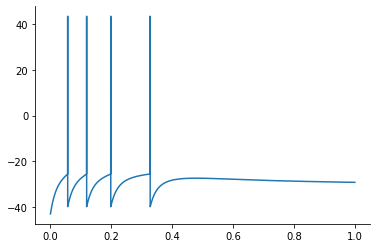

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


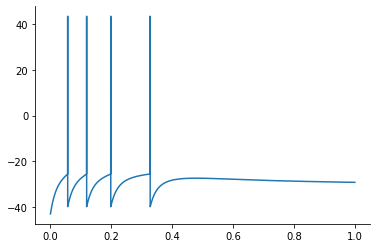

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


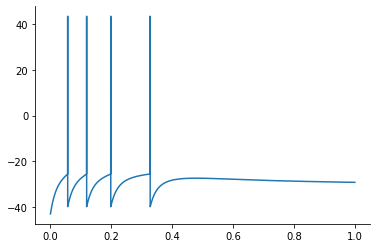

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


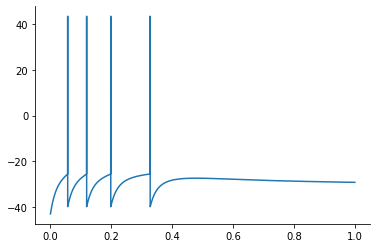

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


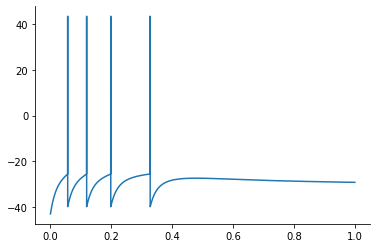

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


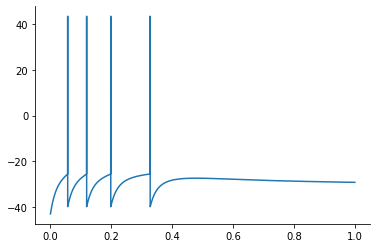

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


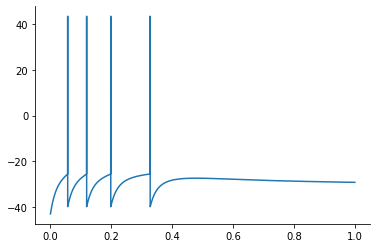

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


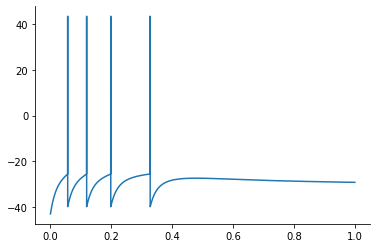

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


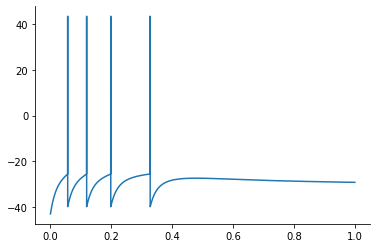

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


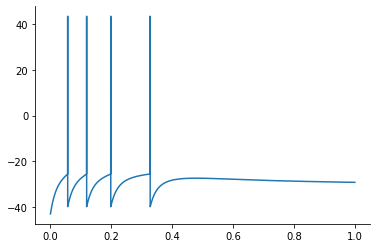

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


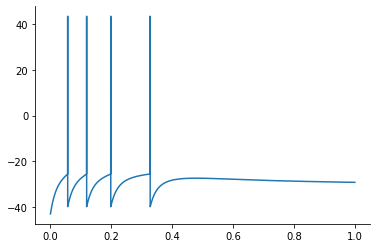

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


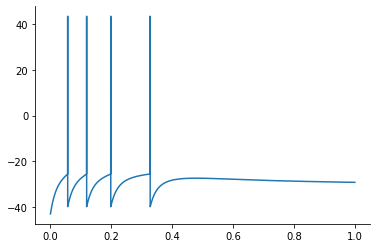

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


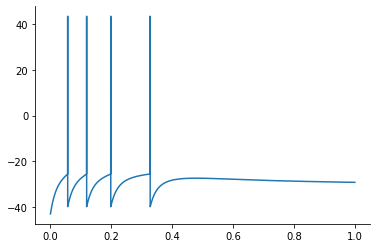

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


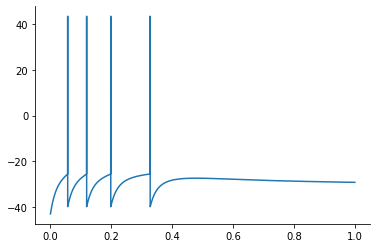

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


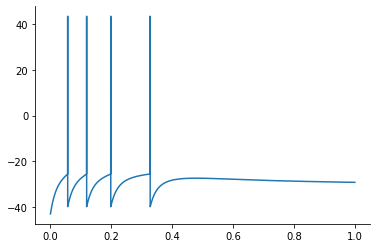

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


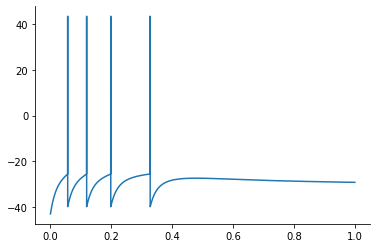

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


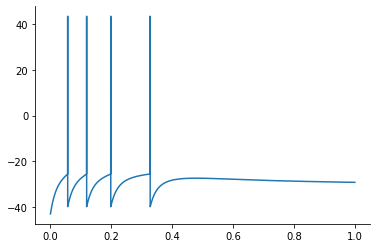

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


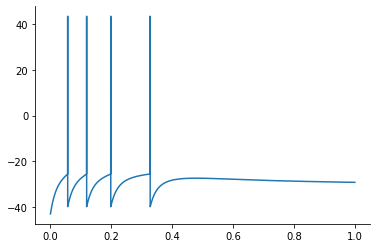

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


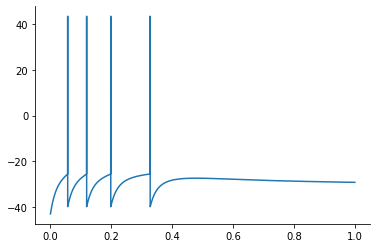

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


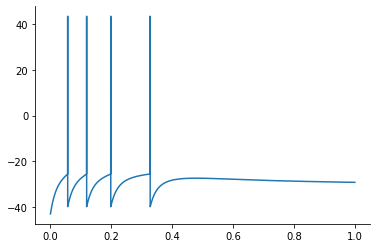

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


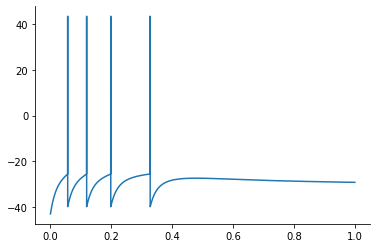

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


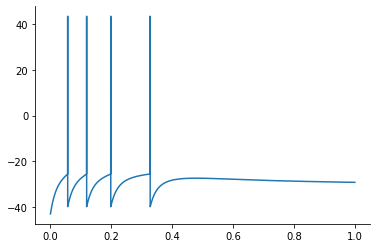

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


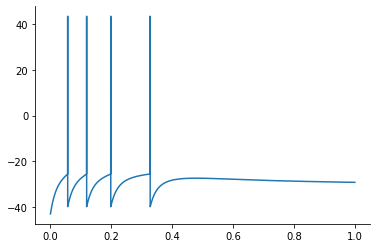

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


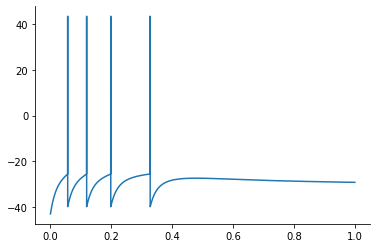

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


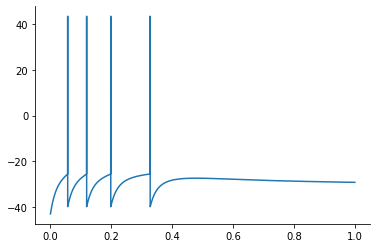

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


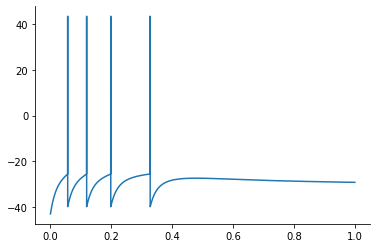

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


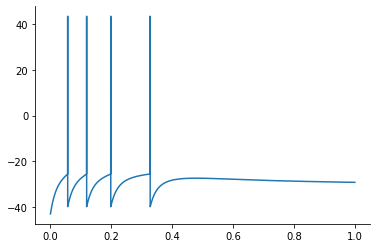

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


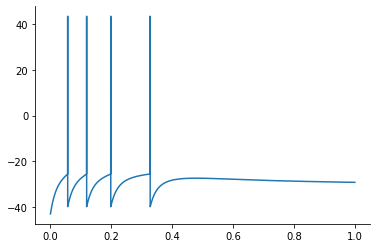

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


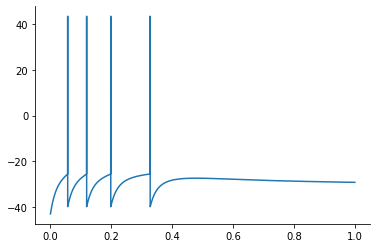

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


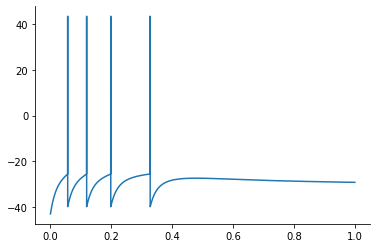

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


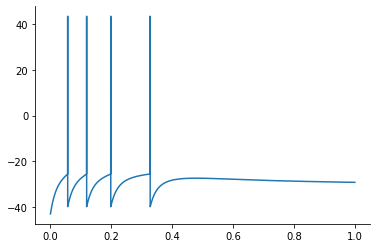

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


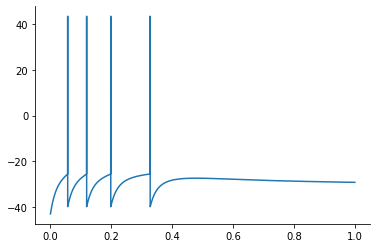

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


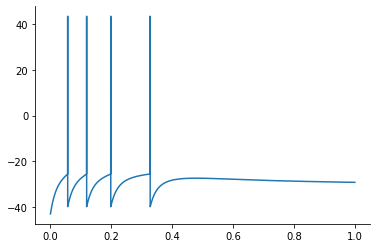

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


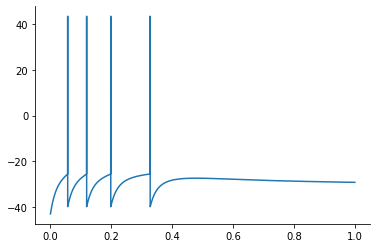

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


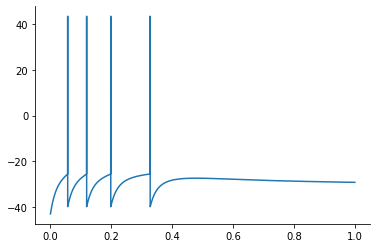

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


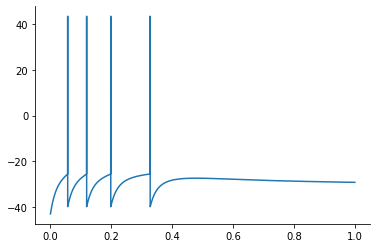

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


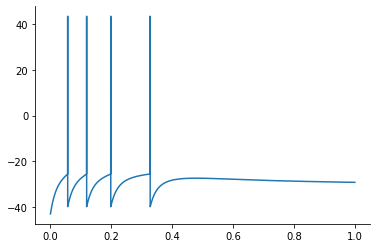

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


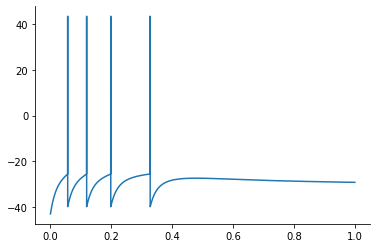

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


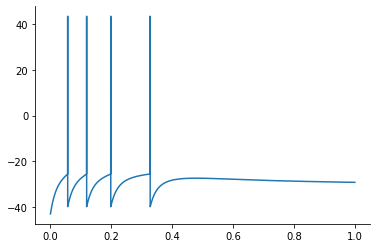

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


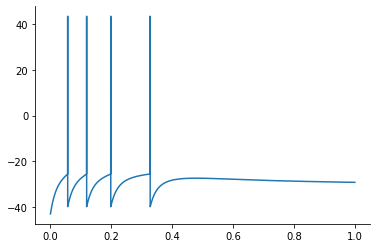

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


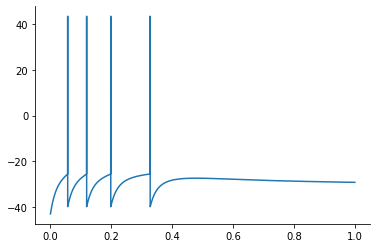

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


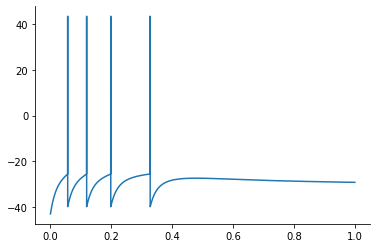

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


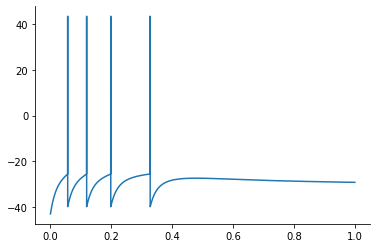

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


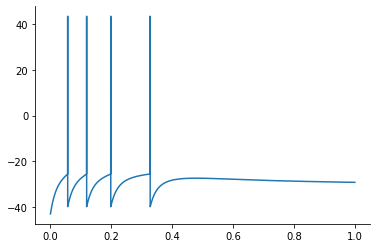

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


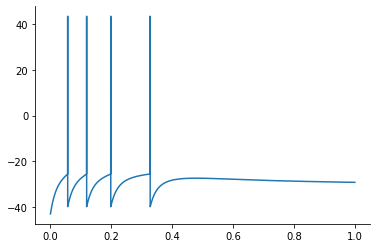

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


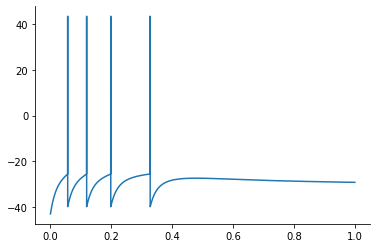

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


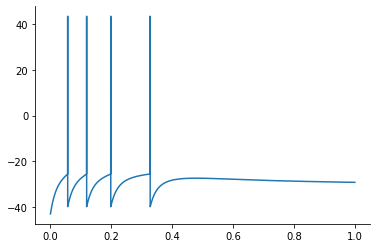

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


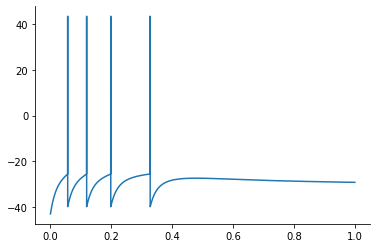

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


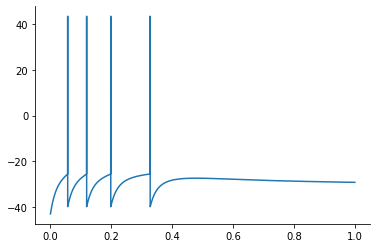

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


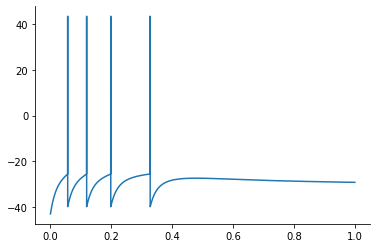

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


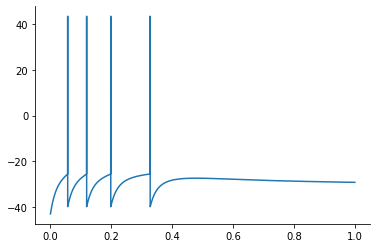

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


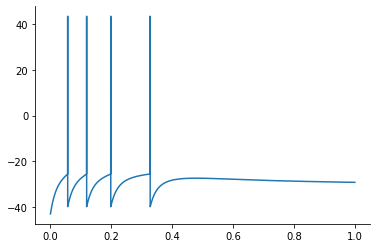

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


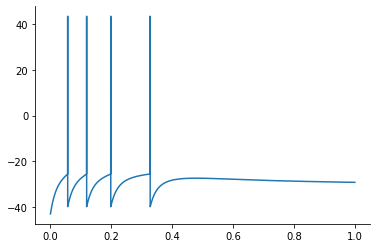

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


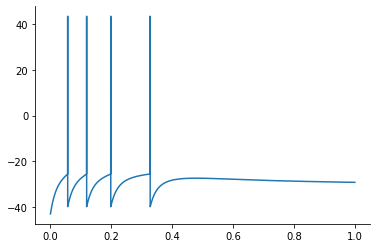

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


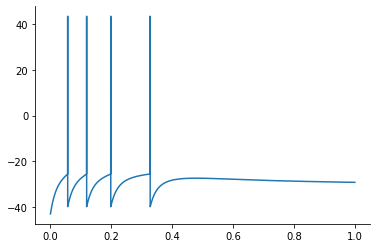

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


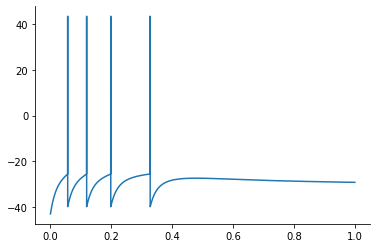

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


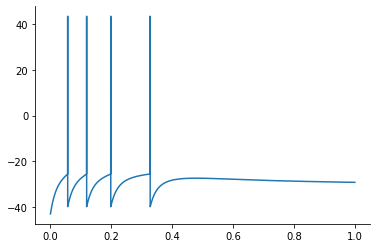

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


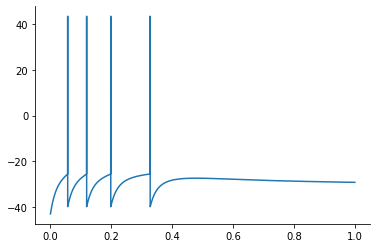

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


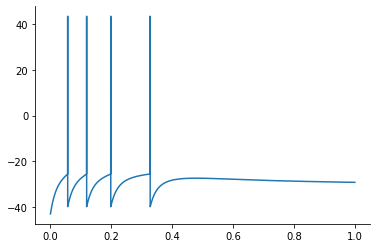

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


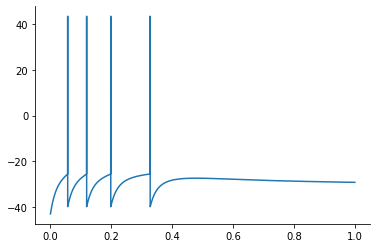

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


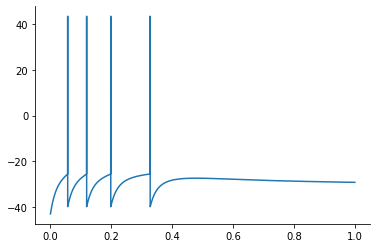

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


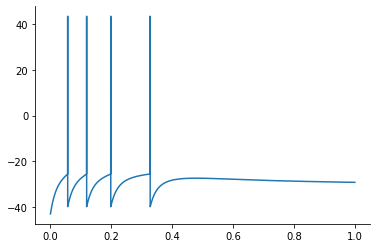

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


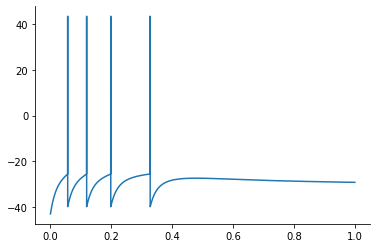

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


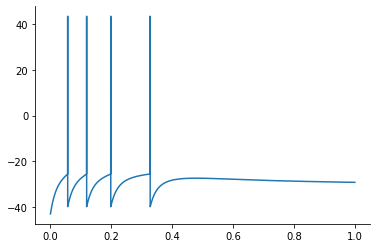

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


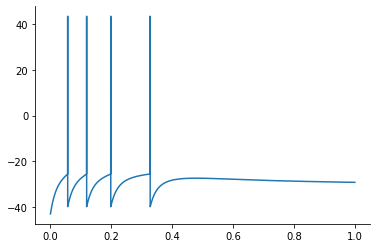

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


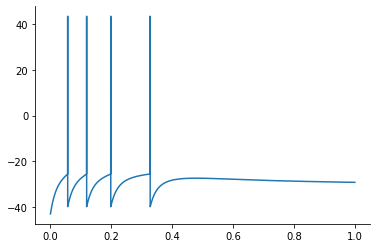

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


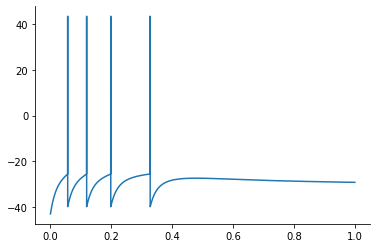

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


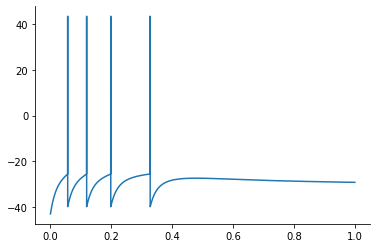

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


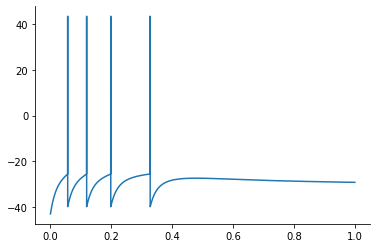

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


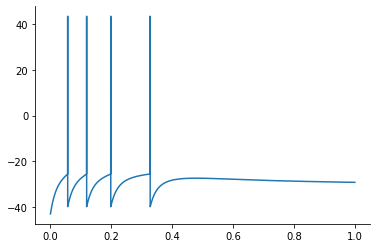

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


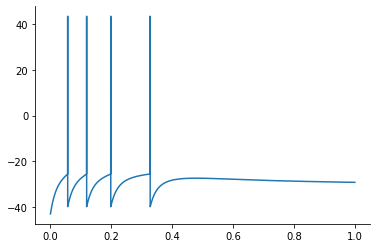

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


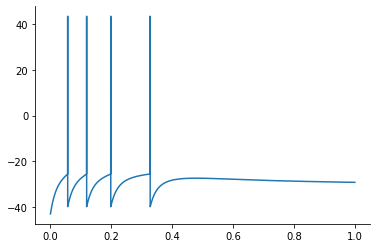

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


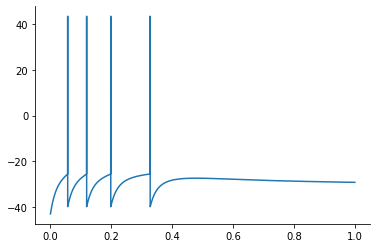

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


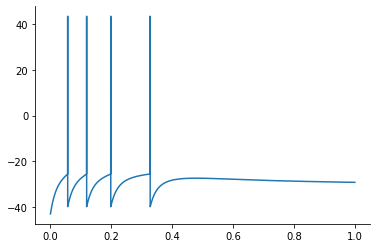

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


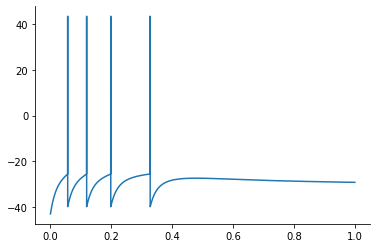

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


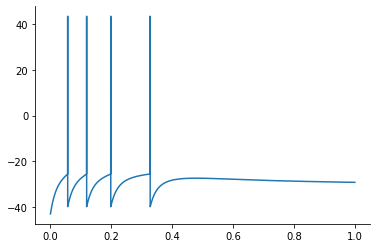

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


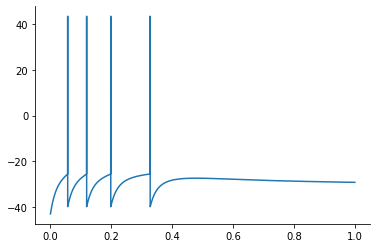

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


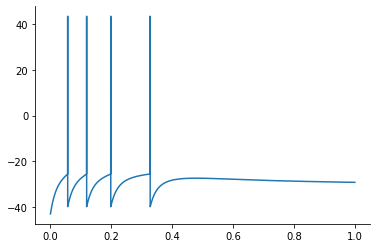

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


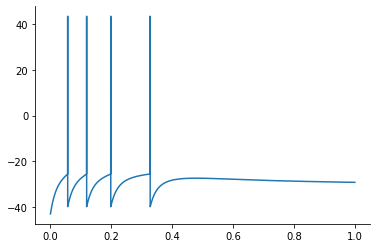

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


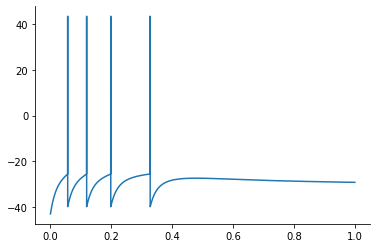

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


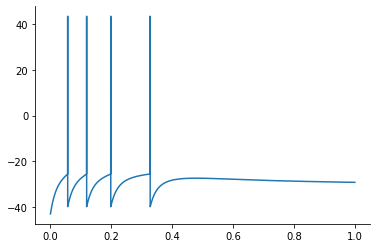

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


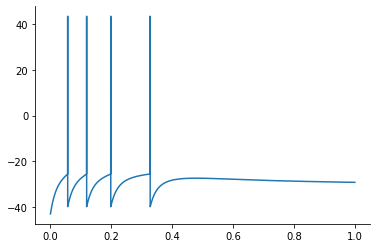

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


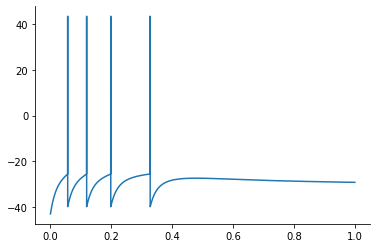

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


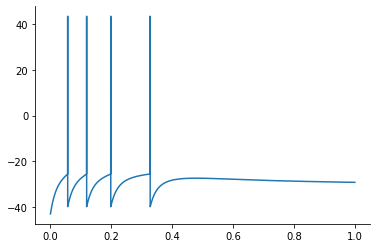

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


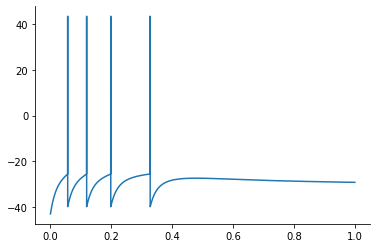

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


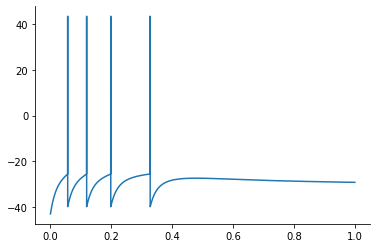

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


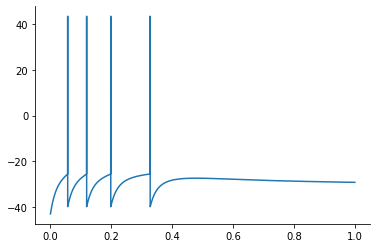

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])
{'cm': 314.61404, 'v_spike': -28.761059, 'v_reset': -39.94592, 'v_rest': -43.14159, 'tau_m': 20.066736, 'a': 6.394542, 'b': 6.394542, 'delta_T': 3.5152404, 'tau_w': 113.14283, 'v_thresh': -25.565388, 'spike_delta': 43.54105}
[[0.2993488  0.49445075 0.17149967 1.1821404  0.329228   0.6974062
  0.2865929  2.3012645  0.8315715  0.26764867 1.3467784  0.6897691
  0.18738773 0.78209406 0.16058269 0.09957938 0.87318367 0.6099633
  1.4793851  1.1250095  0.24633586 0.8294517  0.5485621  0.28938562
  2.2389424  0.8403424  1.0098999  0.40625086 0.82747453 0.7324514
  0.22686157 0.24065745 0.09163875 0.5441203  0.62917554 1.3922894
  0.9466175  0.2835247  0.06559279 0.83074415 0.07668483 0.17756268
  0.7544997  0.5471415  0.70523036 0.7489357  0.24798624 0.6459536
  0.3885558  0.22898068]]


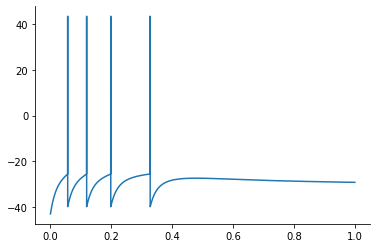

[100, 300, 500, 700]
[0.1, 0.3, 0.5, 0.7]
[0.0567 0.119  0.1982 0.3277] s
tensor([[0.0132]])



In [18]:
seq_length = 1000
input_size = 50
hidden_size = 1
batch_size = 1
epochs = 100
alpha = 100.0
target_times = [100, 300, 500, 700]
#w_in = np.random.randn(hidden_size,input_size) * np.sqrt(2/hidden_size)

w_in = np.random.randn(hidden_size,input_size)* np.sqrt(2/hidden_size)
w_in = [abs(i)/2.0 for i in w_in]
w_in

spikes = torch.distributions.bernoulli.Bernoulli(probs=0.04*torch.ones(seq_length, batch_size, input_size))
z_in = spikes.sample()
result = run_target_spike_time_training(
    w_in=w_in, 
    z_in=z_in,
    alpha=alpha, 
    epochs=epochs, 
    target_times=target_times
)

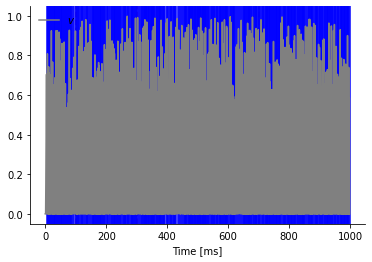

In [19]:
spikes, vs, cs, lambda_vs, lambda_is = result

actual_times = spikes[-1][:,0,0].to_sparse().indices()[0]


for ts in target_times:
    plt.axvline(x=ts, color='red', linestyle='--')

for ts in list(actual_times):
    plt.axvline(x=ts, color='blue', linestyle='-')

plt.plot(vs[-1][:,0], color='grey', label='$v$')
plt.xlabel('Time [ms]')
plt.legend()

We again visualise the error traces over time.

In [20]:
plt.plot(lambda_vs[-2][:,0], label='$\lambda_v$')
plt.xlabel('Time [ms]')
plt.legend()

IndexError: list index out of range

Exercises:
- This task doesn't actually do great, can you think of ways to improve it?
- What additions to the loss could one consider to make the task more stable?
- Explore different values for alpha, target_times and input size, what do you observe?
- Consider a different optimiser
- Consider using biologically plausible neuron parameters